In [2]:
#author: Henrique Boneto

In [3]:
#importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.linalg import toeplitz
sns.set(style='darkgrid')

In [7]:
#configure data
df = pd.read_csv('data/S&P500.csv')
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df['returns'] = ((df['close'] - df['close'].shift(1)) / df['close']).fillna(0)

#define train and test data
df_train = df[df['date'] < '2020-01-29']
df_test = df[df['date'] >= '2020-01-29']
df_train

,date,open,high,low,close,adj_close,volume,returns
0,2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000,0.000000
1,2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000,-0.025385
2,2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4213410000,0.033196
3,2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4104710000,0.006962
4,2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,2574.409912,4083030000,0.009602
...,...,...,...,...,...,...,...,...
264,2020-01-21,3321.030029,3329.790039,3316.610107,3320.790039,3320.790039,4105340000,-0.002659
265,2020-01-22,3330.020020,3337.770020,3320.040039,3321.750000,3321.750000,3619850000,0.000289
266,2020-01-23,3315.770020,3326.879883,3301.870117,3325.540039,3325.540039,3764860000,0.001140
267,2020-01-24,3333.100098,3333.179932,3281.530029,3295.469971,3295.469971,3707130000,-0.009125


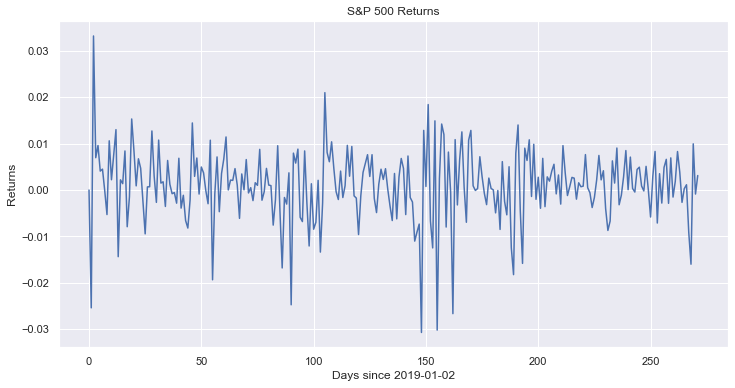

In [5]:
#plotting returns
def plot_returns():
    fig, ax = plt.subplots(figsize=(12,6))
    plt.title('S&P 500 Returns')
    plt.xlabel('Days since 2019-01-02')
    plt.ylabel('Returns')
    ax.plot(df.index, df['returns'])
    plt.savefig('figs/S&P500.png', dpi=300)
plot_returns()

In [6]:
print('Mean:', np.mean(df['returns']))
print('Var:', np.var(df['returns']))

Mean: 0.0009572024132463037
Var: 6.0239953247681715e-05


In [5]:
def check_stationarity(df):
    model = LinearRegression()
    x = np.array(df.index).reshape((-1,1))
    y = np.array(df['returns'])
    model.fit(x, y)
    #slope
    print('Slope:', model.coef_)
    
check_stationarity(df_train)

Slope: [-4.32236132e-06]


In [6]:
#implementation of ACF and PACF
def acf_pacf(df, lags=25):
    x = list(df['returns'])
    mean = np.mean(x)
    gama_0 = np.sum((x-mean)**2)
    auto_corr = []

    for i in range(lags+1):
        gama_t = 0
        for t in range(len(x) - i):
            gama_t += ((x[t] - mean) * (x[t+i] - mean)) / gama_0
        auto_corr.append(gama_t)

    R = toeplitz(auto_corr[:len(auto_corr)-1])
    alpha = auto_corr[1:]
    partial_auto_corr = np.linalg.solve(R, alpha)

    return(auto_corr, partial_auto_corr)

acf, pacf = acf_pacf(df_train)

In [7]:
#implementation of AR
def AR(df, order, n_pred, coefs):
    x = list(df['returns'])
    predictions = []

    for i in range(n_pred):
        pred = np.dot(x[-order:], coefs[:order])
        predictions.append(pred)
        x.append(pred)

    return(predictions)

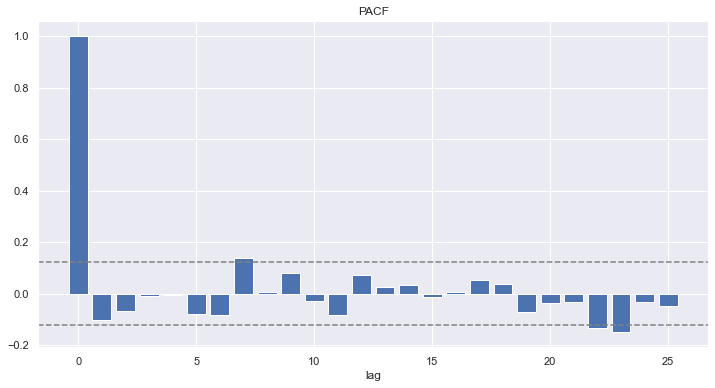

In [8]:
#plotting PACF
def plot_pacf(df, acf, pacf):
    plt.figure(figsize=(12,6))
    plt.title('PACF')
    plt.xlabel('lag')

    #confidence interval
    y = 2/np.sqrt(df.shape[0])
    plt.axhline(y=y, color='gray', linestyle='--')
    plt.axhline(y=-y, color='gray', linestyle='--')

    #PACF
    plt.bar([0,1], [1,pacf[0]], color='b')
    plt.bar(np.arange(1, len(pacf)+1), pacf, color='b')
    plt.savefig('figs/pacf_S&P500.png', dpi=300)

plot_pacf(df_train, acf, pacf)

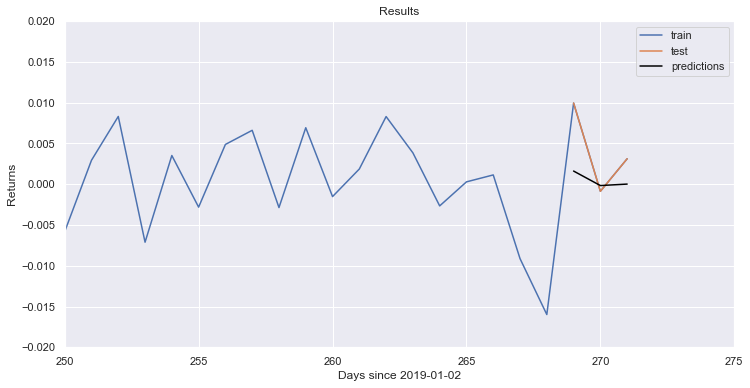

In [9]:
#model params choice
n_pred = df_test.shape[0]
order = 1

#make predictions
pred = AR(df_train, order, n_pred, pacf)

#plot results
plt.figure(figsize=(12,6))
plt.title('Results')
plt.xlabel('Days since 2019-01-02')
plt.ylabel('Returns')

plt.plot(df['returns'], label='train')
plt.plot(df_test['returns'], label='test')
plt.plot(df_test.index, pred, label='predictions', c='black')

plt.xlim([250,275])
plt.ylim([-0.02, 0.02])
plt.legend()
plt.savefig('figs/ar_results_S&P500.png', dpi=300)